# Temporal Fusion Transformer

In [17]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns

import torch
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# tesnorboard
import tensorflow as tf
import tensorboard as tb

# 1. Data load

In [2]:
os.chdir('../..')

In [3]:
os.getcwd()

'c:\\Users\\maxim\\Documents\\GitHub\\gold-forecast'

In [4]:
df = pd.read_csv('data/data_nominal_clean.csv', sep=';', parse_dates=['date'])

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 20)'>

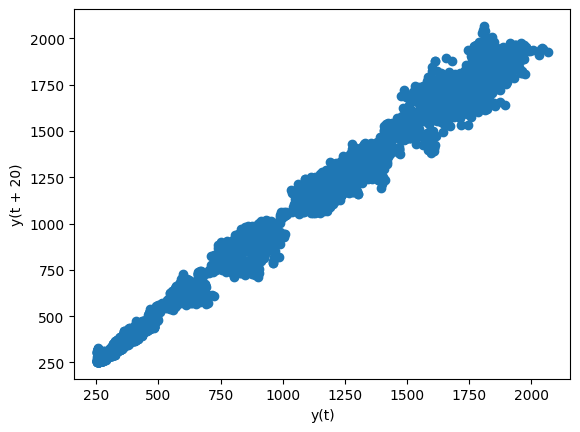

In [5]:
lag_plot(df.Gold, lag=20)

# 2. Preparing data for the model

Necessary manipulations and creations of new variables

In [6]:
dataset = df.shift(20)
dataset['Gold_y'] = df['Gold'] # adding shifted variable of gold
dataset['grp'] = 1 # TFT requires group, adding one group for all since this only has one
dataset.dropna(inplace=True) # dropping nan since the previous shift
dataset['time_idx'] = dataset.reset_index(drop=True).index # creating time index - basically date that is digestible for TFT
dataset

,date,Gold,CrudeOil,S&P500,FTSE250,Gold_y,grp,time_idx
20,1986-01-02,326.30,25.56,209.59,1417.26,358.00,1,0
21,1986-01-03,326.75,26.00,210.88,1424.61,350.50,1,1
22,1986-01-06,328.00,26.53,210.65,1430.96,347.30,1,2
23,1986-01-07,330.00,25.85,213.80,1421.22,338.60,1,3
24,1986-01-08,332.60,25.87,207.97,1408.79,337.30,1,4
...,...,...,...,...,...,...,...,...
9144,2022-11-30,1753.50,80.48,4080.11,19163.33,1813.75,1,9124
9145,2022-12-01,1803.15,81.06,4076.57,19409.42,1843.25,1,9125
9146,2022-12-02,1784.75,79.86,4071.70,19363.28,1857.30,1,9126
9147,2022-12-05,1776.80,76.83,3998.84,19329.58,1834.00,1,9127


In [7]:
dataset.dtypes

date        datetime64[ns]
Gold               float64
CrudeOil           float64
S&P500             float64
FTSE250            float64
Gold_y             float64
grp                  int64
time_idx             int64
dtype: object

In [8]:
max_prediction_length = 20 # We will predict last 20 days 
max_encoder_length = max_prediction_length*4
training_cutoff = dataset["time_idx"].max() - max_prediction_length #validation on last 20 days

In [9]:
training_cutoff

9108

Creating TimeSeriesDataset for training and validation, specifying all variables and additional arguments for the model

In [10]:
training = TimeSeriesDataSet(
    dataset[lambda x: x.time_idx<=training_cutoff],
    target="Gold_y",
    group_ids= ["grp"],
    time_idx="time_idx",
    min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["Gold_y","CrudeOil","S&P500","FTSE250","Gold"],
    target_normalizer=GroupNormalizer(
        groups=["grp"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(
    training,
    dataset,
    predict=True,
    stop_randomization=True
)

Training and validation dataloaders

In [11]:
batch_size = 32

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=7)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10, num_workers=7)

#load the first batch
x, y = next(iter(train_dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[ 259.1500,  260.1500,  260.7000,  ...,  321.7500,  321.0000,
          315.7500],
        [1223.9500, 1223.8000, 1220.9500,  ..., 1211.8500, 1222.4000,
         1221.6000],
        [ 386.2000,  385.9000,  386.5500,  ...,  397.9000,  399.9000,
          400.3500],
        ...,
        [ 587.0000,  588.0000,  586.5000,  ...,  614.3000,  639.0000,
          637.1000],
        [ 362.7500,  354.2500,  354.2500,  ...,  381.9500,  388.0000,
          383.5000],
        [ 367.7000,  366.4000,  363.0500,  ...,  386.0000,  386.5000,
          386.9500]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


tensor([[ 311.7500,  

# 3. Modeling
## A) Baseline model

In [12]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
Missing logger folder: c:\Users\maxim\Documents\GitHub\gold-forecast\lightning_logs


36.40245819091797

## B) Temporal Fusion Transformer
Specifying model parameters

In [13]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs", log_graph=True)  

trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto', 
    devices='auto',
    enable_model_summary=True,
    gradient_clip_val=0.1,
    #fast_dev_run=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    log_every_n_steps=1)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=4,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=4,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=1,
    optimizer='Ranger', 
    reduce_on_plateau_patience=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


Fitting the model

In [14]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
    )

Missing logger folder: lightning_logs\lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 72    
4  | static_variable_selection          | VariableSelectionNetwork        | 378   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 802   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 96    
7  | static_context_variable_selection  | GatedResidualNetwork            | 88    
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 88    
9  | static_context_initial

Epoch 0: 100%|██████████| 284/284 [01:56<00:00,  2.45it/s, v_num=0, train_loss_step=196.0, val_loss=466.0, train_loss_epoch=324.0]

Metric val_loss improved. New best score: 466.106


Epoch 1: 100%|██████████| 284/284 [02:04<00:00,  2.28it/s, v_num=0, train_loss_step=57.40, val_loss=52.00, train_loss_epoch=85.60]

Metric val_loss improved by 414.074 >= min_delta = 0.0001. New best score: 52.032


Epoch 2: 100%|██████████| 284/284 [02:04<00:00,  2.28it/s, v_num=0, train_loss_step=35.40, val_loss=20.10, train_loss_epoch=39.10]

Metric val_loss improved by 31.893 >= min_delta = 0.0001. New best score: 20.139


Epoch 6: 100%|██████████| 284/284 [02:04<00:00,  2.29it/s, v_num=0, train_loss_step=19.20, val_loss=20.10, train_loss_epoch=24.90]

Metric val_loss improved by 0.048 >= min_delta = 0.0001. New best score: 20.091


Epoch 8: 100%|██████████| 284/284 [01:53<00:00,  2.50it/s, v_num=0, train_loss_step=26.90, val_loss=18.80, train_loss_epoch=21.90]

Metric val_loss improved by 1.330 >= min_delta = 0.0001. New best score: 18.761


Epoch 10: 100%|██████████| 284/284 [02:01<00:00,  2.34it/s, v_num=0, train_loss_step=20.30, val_loss=18.70, train_loss_epoch=20.70]

Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 18.735


Epoch 12: 100%|██████████| 284/284 [02:05<00:00,  2.26it/s, v_num=0, train_loss_step=24.00, val_loss=17.60, train_loss_epoch=19.60]

Metric val_loss improved by 1.115 >= min_delta = 0.0001. New best score: 17.621


Epoch 17: 100%|██████████| 284/284 [02:20<00:00,  2.03it/s, v_num=0, train_loss_step=18.50, val_loss=27.00, train_loss_epoch=18.70]

Monitored metric val_loss did not improve in the last 5 records. Best score: 17.621. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 284/284 [02:20<00:00,  2.02it/s, v_num=0, train_loss_step=18.50, val_loss=27.00, train_loss_epoch=18.70]


# 4. Plotting and metrics
Loading the model

In [15]:
# best_model_path = trainer.checkpoint_callback.on_load_checkpoint
# print(best_model_path) # this didnt work :(
best_tft = TemporalFusionTransformer.load_from_checkpoint(r'lightning_logs\lightning_logs\version_0\checkpoints\epoch=17-step=5112.ckpt', strict=False)

## A) Getting predictions and plotting them for variables

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pytorch_forecasting\models\base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(valu

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Gold_y_center': <Figure size 1000x500 with 2 Axes>,
 'Gold_y_scale': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Gold_y': <Figure size 1000x500 with 2 Axes>,
 'CrudeOil': <Figure size 1000x500 with 2 Axes>,
 'S&P500': <Figure size 1000x500 with 2 Axes>,
 'FTSE250': <Figure size 1000x500 with 2 Axes>,
 'Gold': <Figure size 1000x500 with 2 Axes>}

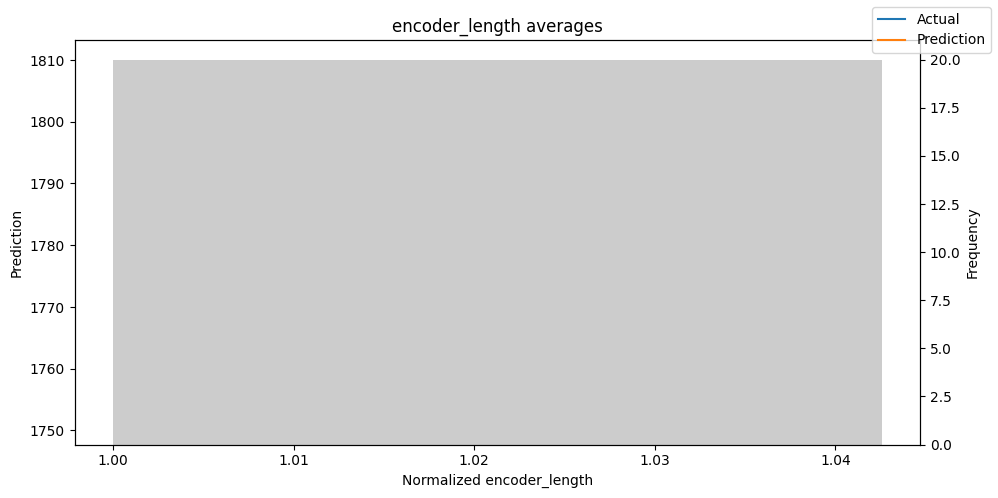

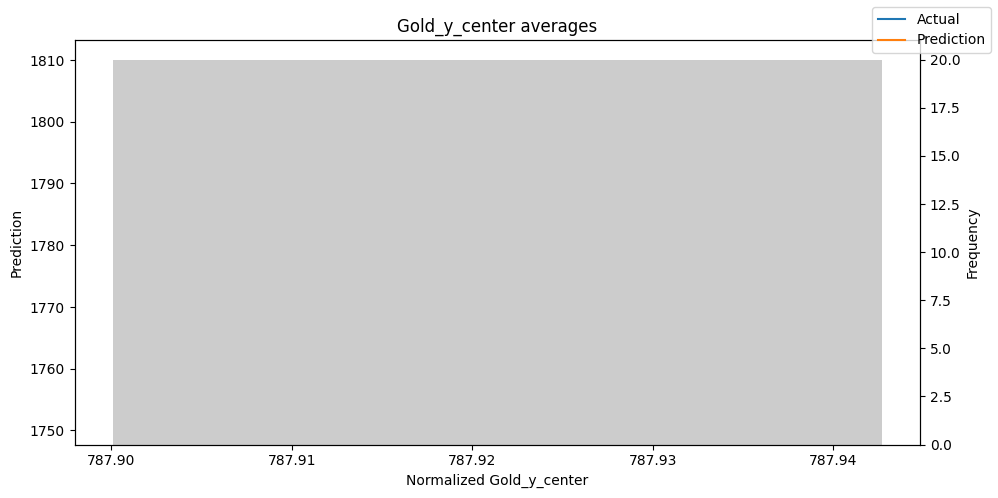

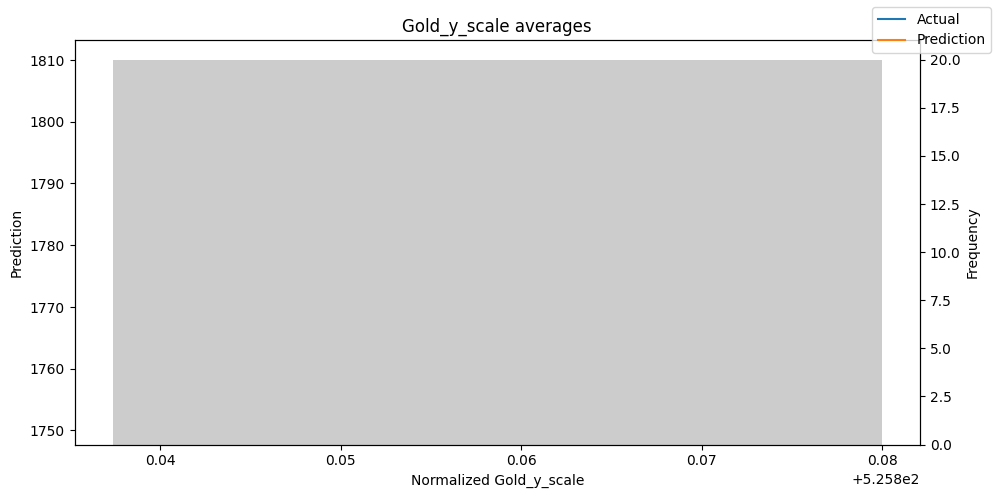

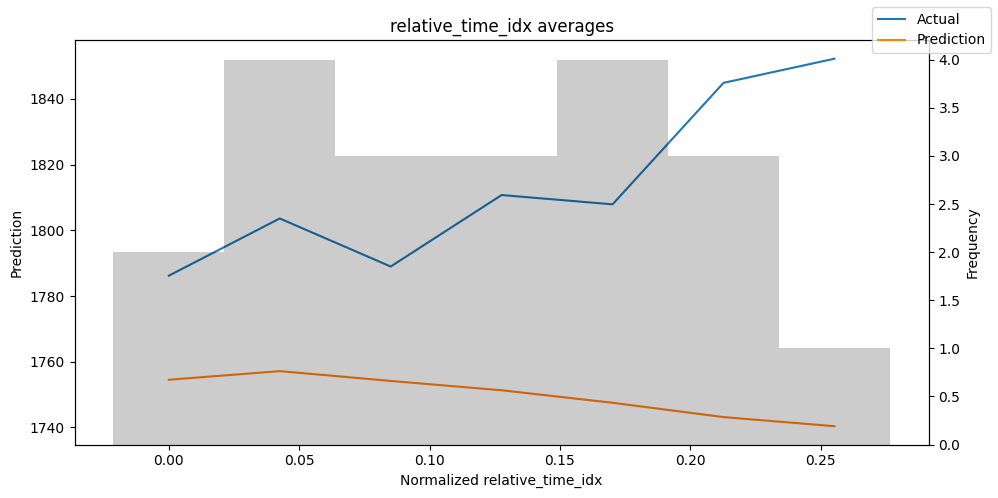

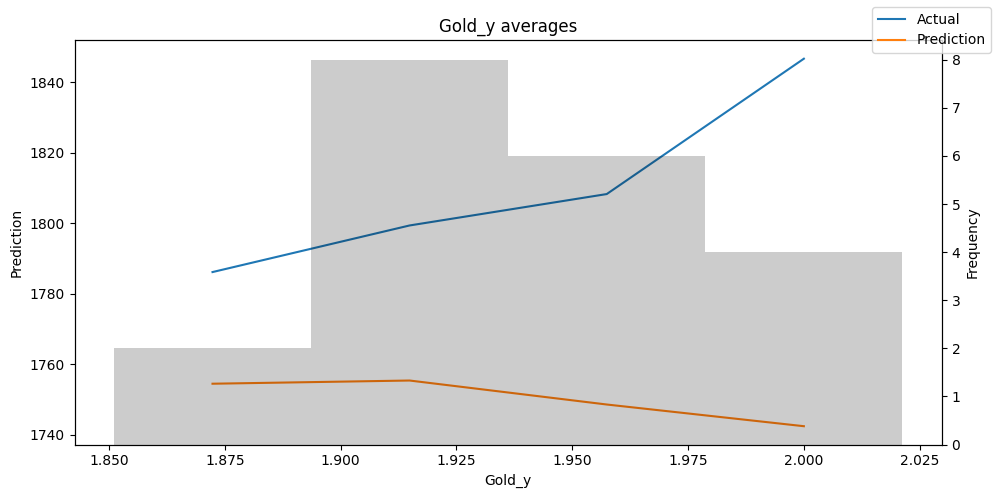

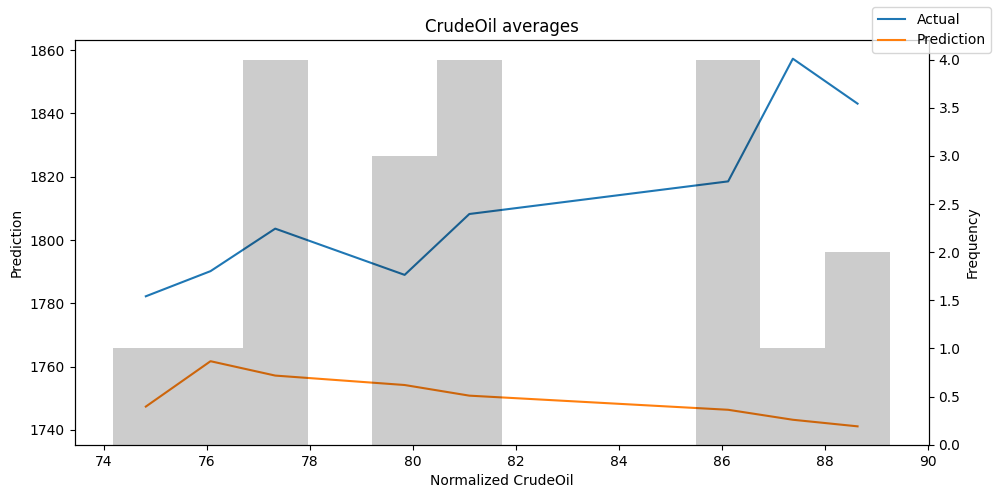

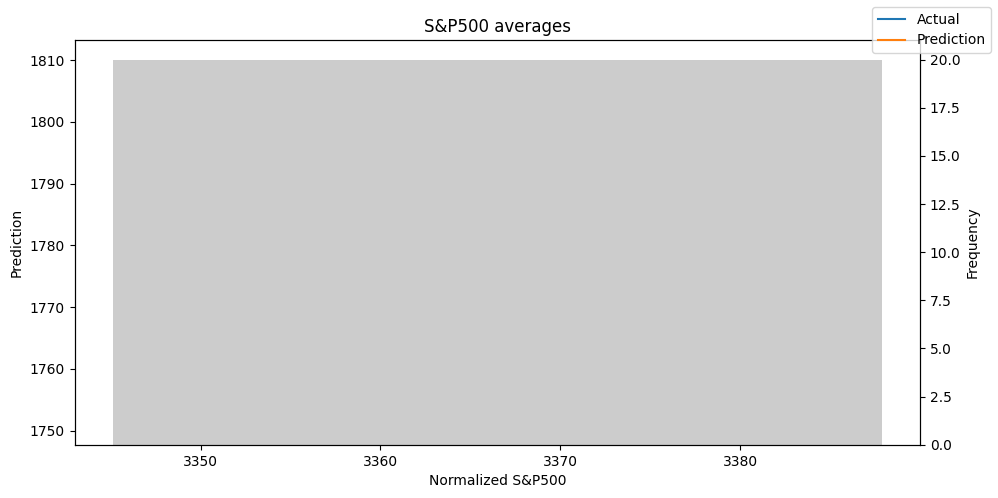

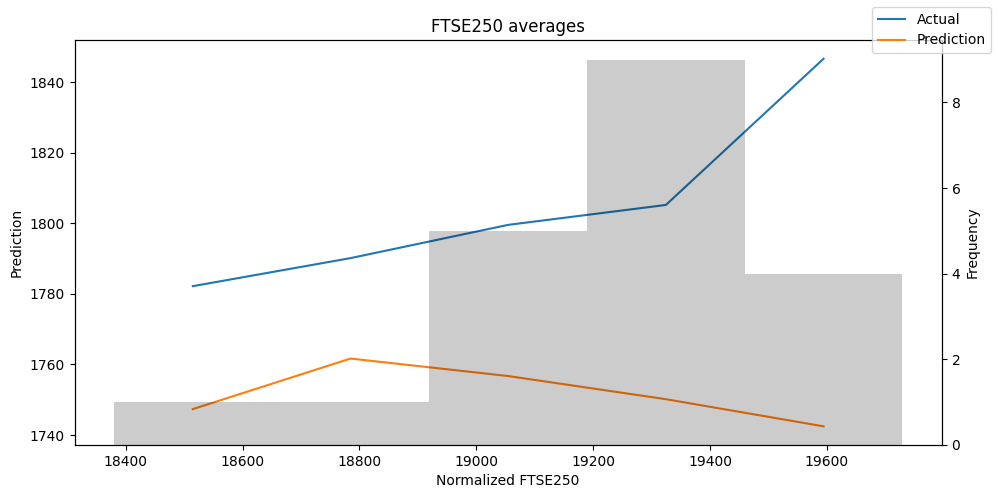

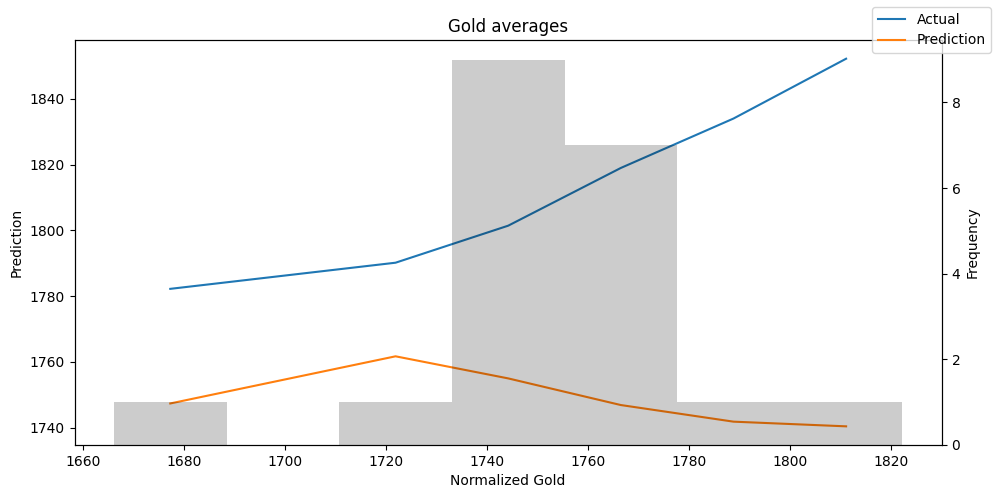

In [16]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [18]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(59.5118)

In [19]:
MAPE()(predictions.output, predictions.y)

tensor(0.0327)

In [20]:
MASE()(predictions.output, predictions.y)

TypeError: MASE.update() missing 1 required positional argument: 'encoder_target'

In [21]:
RMSE()(predictions.output, predictions.y)

tensor(64.9898)

In [22]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

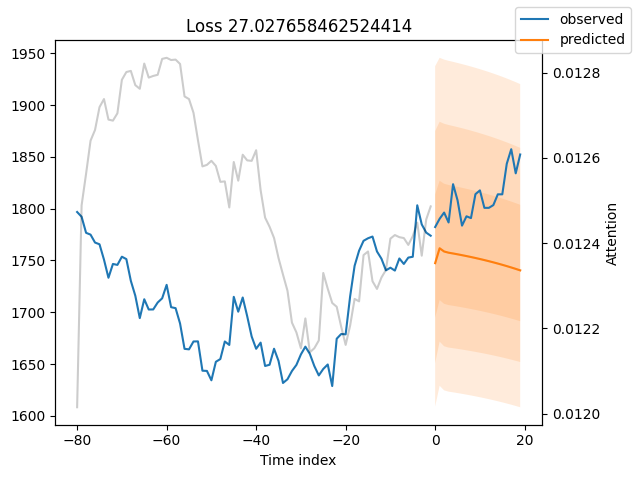

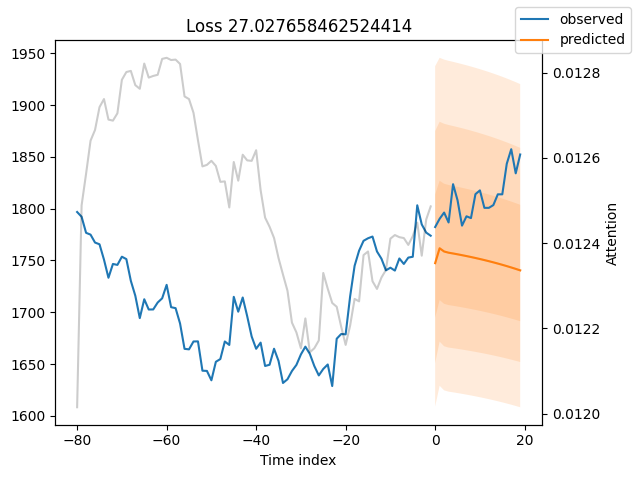

In [25]:
idx = 0
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

## B) Interpretation plots

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

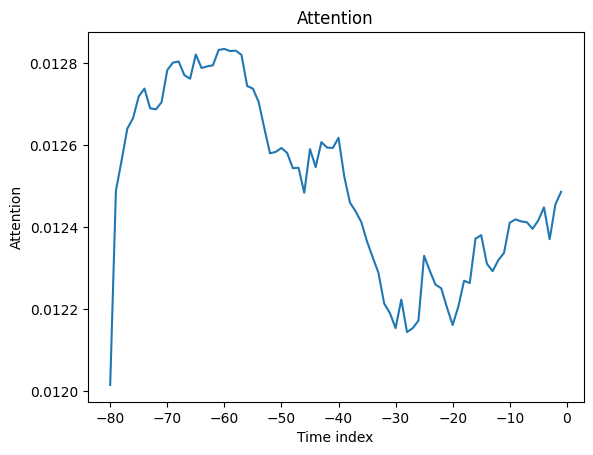

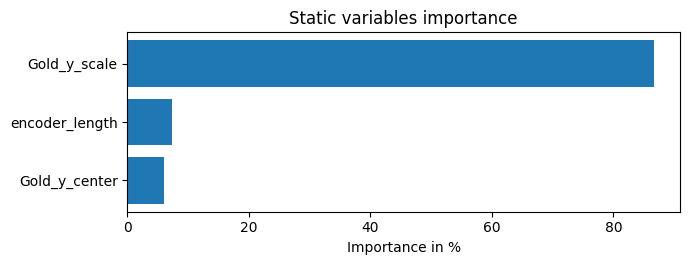

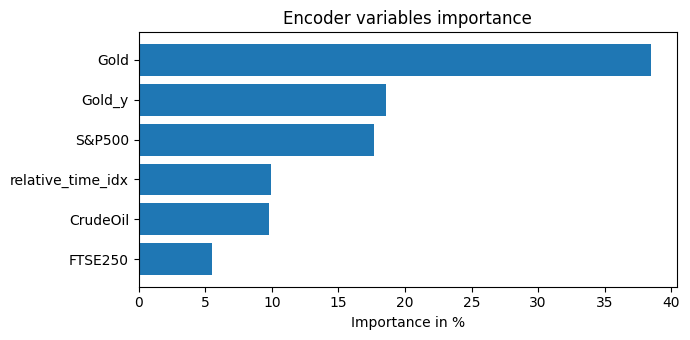

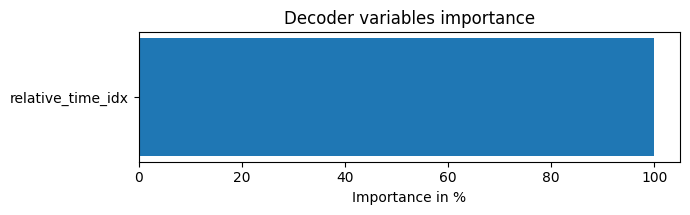

In [26]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)